In [1]:
%matplotlib inline


# 1 - An introduction to Stone Soup: using the Kalman filter


This notebook is designed to introduce some of the basic features of Stone Soup using a single
target scenario and a Kalman filter as an example.

## Background and notation

Let $p(\mathbf{x}_{k})$, the probability distribution over
$\mathbf{x}_{k} \in \mathbb{R}^n$, represent a hidden state at some discrete point
$k$. The $k$ is most often interpreted as a timestep, but could be any sequential
index (hence we don't use $t$). The measurement is given by
$\mathbf{z}_{k} \in \mathbb{R}^m$.

In Stone Soup, objects derived from the :class:`~.State` class carry information on a variety of
states, whether they be hidden states, observations, ground truth. Minimally, a state will
comprise a :class:`~.StateVector` and a timestamp. These can be extended. For example the
:class:`~.GaussianState` is parameterised by a mean state vector and a covariance matrix. (We'll
see this in action later.)

Our goal is to infer $p(\mathbf{x}_{k})$, given a sequence of measurements
$\mathbf{z}_{1}, ..., \mathbf{z}_{k}$, (which we'll write as $\mathbf{z}_{1:k}$). In
general $\mathbf{z}$ can include clutter and false alarms. We'll defer those complications
to later tutorials and assume, for the moment, that all measurements are generated by a target,
and that detecting the target at each timestep is certain ($p_d = 1$ and
$p_{fa} = 0$).

### Prediction

We proceed under the Markovian assumption that $p(\mathbf{x}_k) = \int_{-\infty} ^{\infty}
p(\mathbf{x}_k|\mathbf{x}_{k-1}) p(\mathbf{x}_{k-1}) d \mathbf{x}_{k-1}$, meaning that the
distribution over the state of an object at time $k$ can be predicted entirely from its
state at previous time $k-1$. If our understanding of $p(\mathbf{x}_{k-1})$ was
informed by a series of measurements up to and including timestep $k-1$, we can write

\begin{align}p(\mathbf{x}_k|\mathbf{z}_{1:k-1}) =
          \int_{-\infty}^{\infty} p(\mathbf{x}_k|\mathbf{x}_{k-1})
          p(\mathbf{x}_{k-1}|\mathbf{z}_{1:k-1})d \mathbf{x}_{k-1}\end{align}

This is known as the *Chapman-Kolmogorov* equation. In Stone Soup we refer to this process as
*prediction* and to an object that undertakes it as a :class:`~.Predictor`. A predictor requires
a *state transition model*, namely a function which undertakes
$\mathbf{x}_{k|k-1} = f(\mathbf{x}_{k-1}, \mathbf{w}_k)$, where $\mathbf{w}_k$ is a
noise term. Stone Soup has transition models derived from the :class:`~.TransitionModel` class.

### Update

We assume a sensor measurement is generated by some stochastic process represented by a function,
$\mathbf{z}_k = h(\mathbf{x}_k, \boldsymbol{\nu}_k)$ where $\boldsymbol{\nu}_k$ is
the noise.

The goal of the update process is to generate the *posterior state estimate*, from the prediction
and the measurement. It does this by way of Bayes' rule,

\begin{align}p(\mathbf{x}_k | \mathbf{z}_{1:k}) =
          \frac{ p(\mathbf{z}_{k} | \mathbf{x}_k) p(\mathbf{x}_k | \mathbf{z}_{1:k-1})}
          {p(\mathbf{z}_k)}\end{align}

where $p(\mathbf{x}_k | \mathbf{z}_{1:k-1})$ is the output of the prediction stage,
$p(\mathbf{z}_{k} | \mathbf{x}_k)$ is known as the likelihood, and $p(\mathbf{z}_k)$
the evidence. In Stone Soup, this calculation is undertaken by the :class:`~.Updater` class.
Updaters use a :class:`~.MeasurementModel` class which models the effect of $h(\cdot)$.

<img src="https://stonesoup.rtfd.io/en/v0.1b9/_static/predict_update.png" width="500" alt="Pictorial representation of a single predict-update step">

This figure represents a single instance of this predict-update process. It shows a prior
distribution, at the bottom left, a prediction (dotted ellipse), and posterior (top right)
calculated after a measurement update. We then proceed recursively, the posterior distribution at
$k$ becoming the prior for the next measurement timestep, and so on.



## A nearly-constant velocity example

We're going to set up a simple scenario in which a target moves at constant velocity with the
addition of some random noise, (referred to as a *nearly constant velocity* model).

As is customary in Python scripts we begin with some imports. (These ones allow us access to
mathematical and timing functions.)



In [2]:
import numpy as np
from datetime import datetime, timedelta

### Simulate a target

We consider a 2d Cartesian scheme where the state vector is
$[x \ \dot{x} \ y \ \dot{y}]^T$.  That is, we'll model the target motion as a position
and velocity component in each dimension. The units used are unimportant, but do need to be
consistent.

To start we'll create a simple truth path, sampling at 1
second intervals. We'll do this by employing one of Stone Soup's native transition models.

These inputs are required:



In [3]:
from stonesoup.types.groundtruth import GroundTruthPath, GroundTruthState
from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel, \
                                               ConstantVelocity

# And the clock starts
start_time = datetime.now()

We note that it can sometimes be useful to fix our random number generator in order to probe a
particular example repeatedly.



In [4]:
np.random.seed(1991)

The :class:`~.ConstantVelocity` class creates a one-dimensional constant velocity model with
Gaussian noise. For this simulation $\mathbf{x}_k  = F_k \mathbf{x}_{k-1} + \mathbf{w}_k$,
$\mathbf{w}_k \sim \mathcal{N}(0,Q)$, with

$$
\begin{align}F_{k} &= \begin{bmatrix}
                    1 & \triangle t \\
                    0 & 1 \\
                    \end{bmatrix} \\
          Q_k &= \begin{bmatrix}
                  \frac{\triangle t^3}{3} & \frac{\triangle t^2}{2} \\
                  \frac{\triangle t^2}{2} & \triangle t \\
                 \end{bmatrix} q\end{align}
$$
where $q$, the input parameter to :class:`~.ConstantVelocity`, is the magnitude of the
noise per $\triangle t$-sized timestep.



The :class:`~.CombinedLinearGaussianTransitionModel` class takes a number
of 1d models and combines them in a linear Gaussian model of arbitrary dimension, $D$.

$$
\begin{align}F_{k}^{D} &= \begin{bmatrix}
                       F_k^{1} &  & \mathbf{0} \\
                       & \ddots &  \\
                       \mathbf{0} & & F_k^d \\
                       \end{bmatrix}\\
          Q_{k}^{D} &= \begin{bmatrix}
                       Q_k^{1} &  & \mathbf{0} \\
                       & \ddots &  \\
                       \mathbf{0} & & Q_k^d \\
                       \end{bmatrix} \end{align}
$$
We want a 2d simulation, so we'll do:



In [5]:
q_x = 0.05
q_y = 0.05
transition_model = CombinedLinearGaussianTransitionModel([ConstantVelocity(q_x),
                                                          ConstantVelocity(q_y)])

A 'truth path' is created starting at (0,0) moving to the NE at one distance unit per (time) step in each dimension.



In [6]:
truth = GroundTruthPath([GroundTruthState([0, 1, 0, 1], timestamp=start_time)])

num_steps = 20
for k in range(1, num_steps + 1):
    truth.append(GroundTruthState(
        transition_model.function(truth[k-1], noise=True, time_interval=timedelta(seconds=1)),
        timestamp=start_time+timedelta(seconds=k)))

Thus the ground truth is generated and we can plot the result.

Stone Soup has an in-built plotting class which can be used to plot
ground truths, measurements and tracks in a consistent format. It can be accessed by importing
the class :class:`Plotter` from Stone Soup as below.

Note that the mapping argument is [0, 2] because those are the x and y position indices from our state vector.



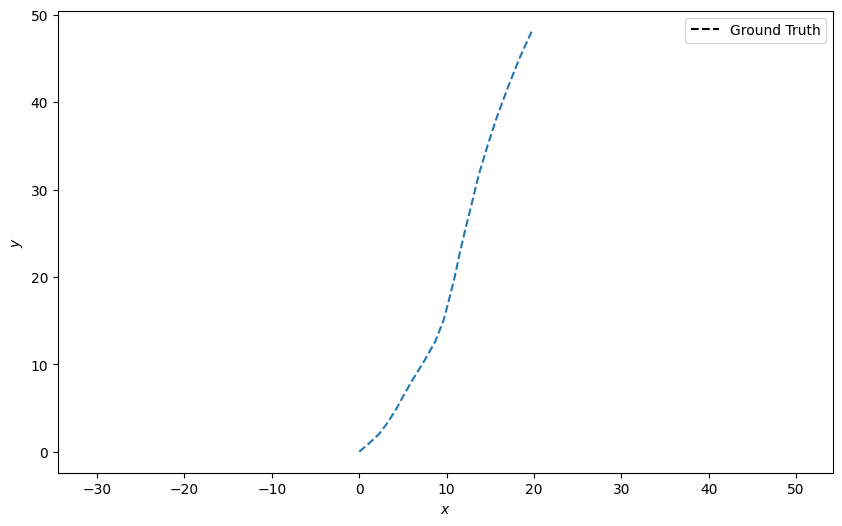

In [7]:
from stonesoup.plotter import Plotter
plotter = Plotter()
plotter.plot_ground_truths(truth, [0, 2])

We can check the $F_k$ and $Q_k$ matrices (generated over a 1s period).



In [8]:
transition_model.matrix(time_interval=timedelta(seconds=1))

array([[1., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 1.],
       [0., 0., 0., 1.]])

In [9]:
transition_model.covar(time_interval=timedelta(seconds=1))

array([[0.01666667, 0.025     , 0.        , 0.        ],
       [0.025     , 0.05      , 0.        , 0.        ],
       [0.        , 0.        , 0.01666667, 0.025     ],
       [0.        , 0.        , 0.025     , 0.05      ]])

At this point you can play with the various parameters and see how it affects the simulated
output.



### Simulate measurements

We'll use one of Stone Soup's measurement models in order to generate
measurements from the ground truth. For the moment we assume a 'linear' sensor which detects the
position, but not velocity, of a target, such that
$\mathbf{z}_k = H_k \mathbf{x}_k + \boldsymbol{\nu}_k$,
$\boldsymbol{\nu}_k \sim \mathcal{N}(0,R)$, with

$$
\begin{align}H_k &= \begin{bmatrix}
                    1 & 0 & 0 & 0\\
                    0  & 0 & 1 & 0\\
                      \end{bmatrix}\\
          R &= \begin{bmatrix}
                  1 & 0\\
                    0 & 1\\
               \end{bmatrix} \omega\end{align}
$$
where $\omega$ is set to 5 initially (but again, feel free to play around).



We're going to need a :class:`~.Detection` type to
store the detections, and a :class:`~.LinearGaussian` measurement model.



In [10]:
from stonesoup.types.detection import Detection
from stonesoup.models.measurement.linear import LinearGaussian

The linear Gaussian measurement model is set up by indicating the number of dimensions in the
state vector and the dimensions that are measured (so specifying $H_k$) and the noise
covariance matrix $R$.



In [11]:
measurement_model = LinearGaussian(
    ndim_state=4,  # Number of state dimensions (position and velocity in 2D)
    mapping=(0, 2),  # Mapping measurement vector index to state index
    noise_covar=np.array([[5, 0],  # Covariance matrix for Gaussian PDF
                          [0, 5]])
    )

Check the output is as we expect



In [12]:
measurement_model.matrix()

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.]])

In [13]:
measurement_model.covar()

CovarianceMatrix([[5, 0],
                  [0, 5]])

Generate the measurements



In [14]:
measurements = []
for state in truth:
    measurement = measurement_model.function(state, noise=True)
    measurements.append(Detection(measurement,
                                  timestamp=state.timestamp,
                                  measurement_model=measurement_model))

Plot the result, again mapping the x and y position values



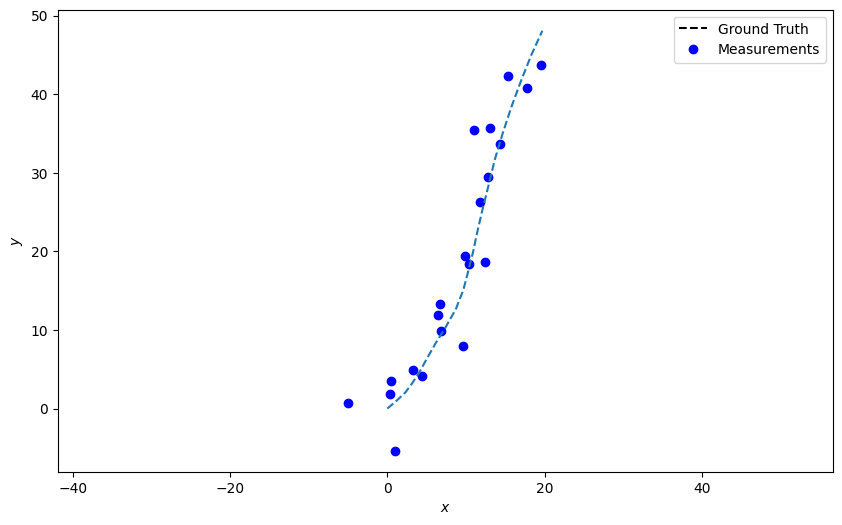

In [15]:
plotter.plot_measurements(measurements, [0, 2])
plotter.fig

At this stage you should have a moderately linear ground truth path (dotted line) with a series
of simulated measurements overplotted (blue circles). Take a moment to fiddle with the numbers in
$Q$ and $R$ to see what it does to the path and measurements.



### Construct a Kalman filter

We're now ready to build a tracker. We'll use a Kalman filter as it's conceptually the simplest
to start with. The Kalman filter is described extensively elsewhere [#]_, [#]_, so for the
moment we just assert that the prediction step proceeds as:

\begin{align}\mathbf{x}_{k|k-1} &= F_{k}\mathbf{x}_{k-1} + B_{k}\mathbf{u}_{k}\\
                P_{k|k-1} &= F_{k}P_{k-1}F_{k}^T + Q_{k},\end{align}

$B_k \mathbf{u}_k$ is a control term which we'll ignore for now (we assume we don't
influence the target directly).

The update step is:

\begin{align}\mathbf{x}_{k} &= \mathbf{x}_{k|k-1} + K_k(\mathbf{z}_k - H_{k}\mathbf{x}_{k|k-1})\\
      P_{k} &= P_{k|k-1} - K_k H_{k} P_{k|k-1}\\\end{align}

where,

\begin{align}K_k &= P_{k|k-1} H_{k}^T S_k^{-1}\\
      S_k &= H_{k} P_{k|k-1} H_{k}^T + R_{k}\end{align}

$\mathbf{z}_k - H_{k}\mathbf{x}_{k|k-1}$ is known as the *innovation* and $S_k$ the
*innovation covariance*; $K_k$ is the *Kalman gain*.



Constructing a predictor and updater in Stone Soup is simple. In a nice division of
responsibility, a :class:`~.Predictor` takes a :class:`~.TransitionModel` as input and
an :class:`~.Updater` takes a :class:`~.MeasurementModel` as input. Note that for now we're using
the same models used to generate the ground truth and the simulated measurements. This won't
usually be possible and it's an interesting exercise to explore what happens when these
parameters are mismatched.



In [16]:
from stonesoup.predictor.kalman import KalmanPredictor
predictor = KalmanPredictor(transition_model)

from stonesoup.updater.kalman import KalmanUpdater
updater = KalmanUpdater(measurement_model)

### Run the Kalman filter
Now we have the components, we can execute the Kalman filter estimator on the simulated data.

In order to start, we'll need to create the first prior estimate. We're going to use the
:class:`~.GaussianState` we mentioned earlier. As the name suggests, this parameterises the state
as $\mathcal{N}(\mathbf{x}_0, P_0)$. By happy chance the initial values are chosen to match
the truth quite well. You might want to manipulate these to see what happens.



In [17]:
from stonesoup.types.state import GaussianState
prior = GaussianState([[0], [1], [0], [1]], np.diag([1.5, 0.5, 1.5, 0.5]), timestamp=start_time)

In this instance data association is done somewhat implicitly. There is one prediction and
one detection per timestep so no need to think too deeply. Stone Soup discourages such
(undesirable) practice and requires that a :class:`~.Prediction` and :class:`~.Detection` are
associated explicitly. This is done by way of a :class:`~.Hypothesis`; the most simple
is a :class:`~.SingleHypothesis` which associates a single predicted state with a single
detection. There is much more detail on how the :class:`~.Hypothesis` class is used in later
tutorials.



In [18]:
from stonesoup.types.hypothesis import SingleHypothesis

With this, we'll now loop through our measurements, predicting and updating at each timestep.
Uncontroversially, a Predictor has :meth:`predict` function and an Updater an :meth:`update` to
do this. Storing the information is facilitated by the top-level :class:`~.Track` class which
holds a sequence of states.



In [19]:
from stonesoup.types.track import Track
track = Track()
for measurement in measurements:
    prediction = predictor.predict(prior, timestamp=measurement.timestamp)
    hypothesis = SingleHypothesis(prediction, measurement)  # Group a prediction and measurement
    post = updater.update(hypothesis)
    track.append(post)
    prior = track[-1]

Plot the resulting track, including uncertainty ellipses



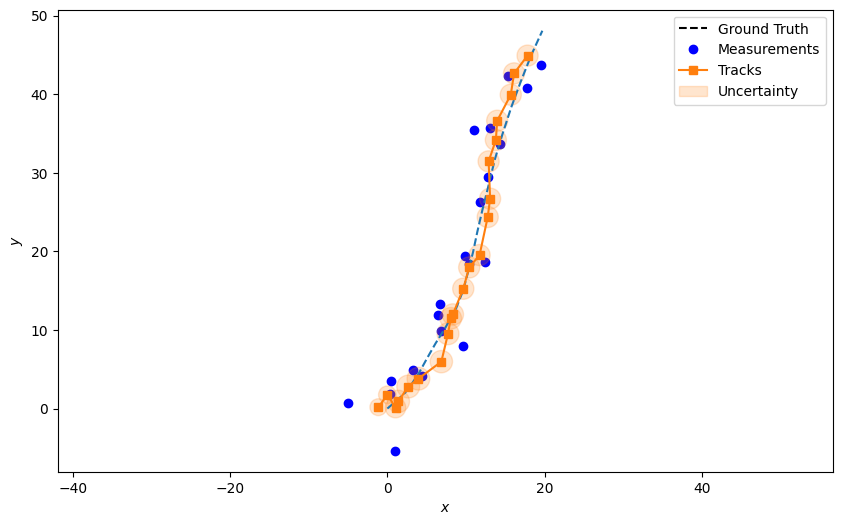

In [20]:
plotter.plot_tracks(track, [0, 2], uncertainty=True)
plotter.fig

## Key points
1. Stone Soup is built on a variety of types of :class:`~.State` object. These can be used to
   represent hidden states, observations, estimates, ground truth, and more.
2. Bayesian recursion is undertaken by the successive applications of predict and update methods
   using a :class:`~.Predictor` and an :class:`~.Updater`. Explicit association of predicted
   states with measurements is necessary. Broadly speaking, predictors apply a
   :class:`~.TransitionModel`, data associators use a
   :class:`~.Hypothesiser` to associate a prediction with a measurement, and updaters use this
   association together with the :class:`~.MeasurementModel` to calculate the posterior state
   estimate.



## References
.. [#] Kalman 1960, A New Approach to Linear Filtering and Prediction Problems, Transactions of
       the ASME, Journal of Basic Engineering, 82 (series D), 35
       (https://pdfs.semanticscholar.org/bb55/c1c619c30f939fc792b049172926a4a0c0f7.pdf?_ga=2.51363242.2056055521.1592932441-1812916183.1592932441)
.. [#] Anderson & Moore 1979, Optimal filtering,
       (http://users.cecs.anu.edu.au/~john/papers/BOOK/B02.PDF)

